In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [2]:
#Import data and give column names
index_names = ['unit_no', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

train = pd.read_csv('../data/train_FD001.txt', sep='\s', header=None, names = col_names)
test = pd.read_csv('../data/test_FD001.txt', sep='\s', header=None, names = col_names)
y_test = pd.read_csv('../data/RUL_FD001.txt', sep='\s', header=None, names = ['RUL'])

keep_columns = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17','s_20','s_21']
train.head()

c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__m

,unit_no,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def scale_data(df, columns):
    sc = MinMaxScaler()
    scaled_data = df.copy()
    scaled_data[columns] = pd.DataFrame(sc.fit_transform(scaled_data[columns]))
    return scaled_data

In [4]:
def scale_data_quantile(df, columns):
    sc = qt = QuantileTransformer(n_quantiles=10, random_state=0)
    scaled_data = df.copy()
    scaled_data[columns] = pd.DataFrame(qt.fit_transform(scaled_data[columns]))
    return scaled_data

In [5]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_no")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_no', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [6]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42) 
def train_val_group_split(x_data, y_data, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(x_data, y_data, groups=groups):
        if print_groups:
            print('train_split_engines', x_data.iloc[idx_train]['unit_no'].unique())
            print('validate_split_engines', x_data.iloc[idx_val]['unit_no'].unique(), '\n')

        x_train = x_data.iloc[idx_train].copy()
        y_train = y_data.iloc[idx_train].copy()
        x_val = x_data.iloc[idx_val].copy()
        y_val = y_data.iloc[idx_val].copy()
    return x_train, y_train, x_val, y_val

In [7]:
def generator_training_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
def generator_data_wrapper(df, sequence_length, columns, unit_nos=np.array([])):
    if unit_nos.size <= 0:
        unit_nos = df['unit_no'].unique()
    #Runs the generator_training_data function for all units
    seperate_unit_gen = (list(generator_training_data(df[df['unit_no']==unit_no], sequence_length, columns))
               for unit_no in unit_nos)
    #Combine the subsets into a new set of sequences    
    combined_units_gen = np.concatenate(list(seperate_unit_gen)).astype(np.float32)
    return combined_units_gen

In [8]:
def generator_labels(df, sequence_length, label_column):
    data = df[label_column].values
    num_elements = data.shape[0]
    #-1 makes sure that the label returned is the last row of the sequence, not the beginning of the next sequence
    return data[sequence_length-1:num_elements, :]

def generator_label_wrapper(df, sequence_length, label, unit_nos=np.array([])):
    if unit_nos.size <= 0:
        unit_nos = df['unit_no'].unique()
        
    seperate_unit_gen = (generator_labels(df[df['unit_no']==unit_no], sequence_length, label) 
                for unit_no in unit_nos)
    comined_units_gen = np.concatenate(list(seperate_unit_gen)).astype(np.float32)
    return comined_units_gen

In [9]:
train = add_remaining_useful_life(train)
#train[index_names+['RUL']].head()

In [10]:
train = scale_data(train, keep_columns)
#train = scale_data_quantile(train, keep_columns)
print(train.shape)

(20631, 27)


In [11]:
x_train, y_train, x_val, y_val = train_val_group_split(train.drop(['RUL'], axis = 1), train[['RUL', 'unit_no']], gss, train['unit_no'])

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100]
validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(16561, 26)
(16561, 2)
(4070, 26)
(4070, 2)


In [30]:
sequence_length = 4
generator_x_train = generator_data_wrapper(x_train, sequence_length, keep_columns)
generator_x_val = generator_data_wrapper(x_val, sequence_length, keep_columns)
print(generator_x_train.shape)
print(generator_x_val.shape)

(16321, 4, 15)
(4010, 4, 15)


In [31]:
generator_y_train = generator_label_wrapper(y_train, sequence_length, ['RUL'])
generator_y_val = generator_label_wrapper(y_val, sequence_length, ['RUL'])
print(generator_y_train.shape)
print(generator_y_val.shape)

(16321, 1)
(4010, 1)


In [27]:
#optimizer = RMSprop(learning_rate=0.0001)
optimizer = Adam(lr=1e-3)
#optimizer = Adam(clipvalue=1)
#optimizer = Adam(clipvalue=1.e-10)

In [28]:
model = Sequential()
model.add(LSTM(256, activation='sigmoid', input_shape=(None, generator_x_train.shape[2]), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer = optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 256)         278528    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 475,777
Trainable params: 475,777
Non-trainable params: 0
_________________________________________________________________


In [32]:
epochs = 1

history = model.fit(generator_x_train, generator_y_train,
                    validation_data=(generator_x_val, generator_y_val),
                    epochs=epochs,
                   batch_size=128)

Train on 16321 samples, validate on 4010 samples
Epoch 1/1
16321/16321 [==============================] - 4s 254us/step - loss: 12481.8648 - val_loss: 10611.0252


In [18]:
model.save_weights('simple_lstm_weights_new.h5')

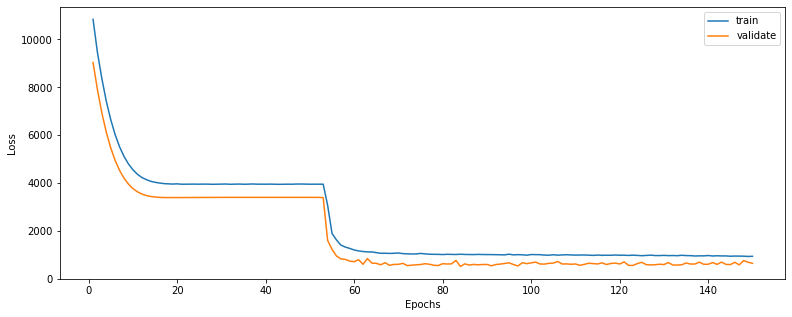

In [19]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [20]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [21]:
# predict and evaluate
y_hat_train = model.predict(generator_x_train)
evaluate(generator_y_train, y_hat_train, 'train')

train set RMSE:29.949586868286133, R2:0.7723738802859358


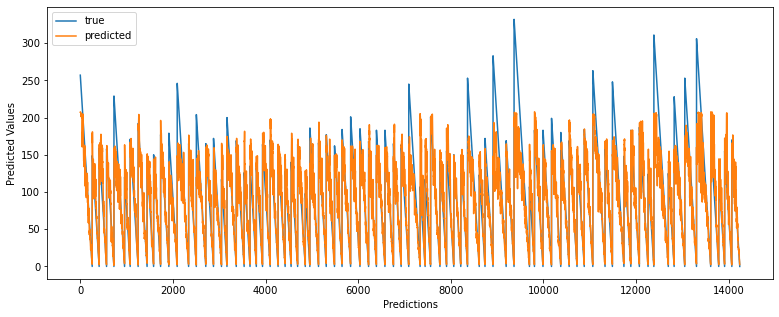

In [24]:
def plot_predictions(y_true, y_predicted):
    plt.figure(figsize=(13,5))
    plt.plot(y_true, label='true')
    plt.plot(y_predicted, label='predicted')
    plt.xlabel('Predictions')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

plot_predictions(generator_y_train ,y_hat_train)